In [98]:
%matplotlib inline

import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from abc import ABC

In [12]:
tables = { 
 "Object": ["objectId", "ra", "dec", "x", "y", "mag_u", "mag_g", "mag_r", "mag_u_err", "mag_g_err", "mag_r_err"],
 "ForcedSource": ['objectId', 'flux', 'flux_err']
}

In [127]:
class ColumnGenerator(ABC):
    
    def __call__(self, cell_id, length):
        """
        Parameters
        ----------
        cell_id : int
            Identifier of which cell on the sky to in which
            coordinates should be generated

        length : int
            Number of coordiantes to generate
            
        Returns
        -------
        columns: tuple
            One or more arrays containing the data for each column
        """
        return NotImplemented

class RaDecGenerator(ColumnGenerator):
    
    def __call__(self, cell_id, length, **kwargs):
        """
        Parameters
        ----------
        cell_id : int
            Identifier of which cell on the sky to in which
            coordinates should be generated

        length : int
            Number of coordiantes to generate

        Returns
        -------
        ra_coords : array
            Array containing the generated RA coordinates.
        dec_coords : array
            Array containing the generated Dec coordinates.    
        """

        ra_limits = ( 360/80 * cell_id, 360/80 * (cell_id + 1))
        dec_limits = (0.0, 5.0)
        ra_delta = max(ra_limits) - min(ra_limits)
        dec_delta = max(dec_limits) - min(dec_limits)
        ra_array = np.random.random(length)*ra_delta + min(ra_limits)
        dec_array = np.random.random(length)*dec_delta + min(dec_limits)
        return (ra_array, dec_array)
    
class ObjIdGenerator(ColumnGenerator):

    def __call__(self, cell_id, length, **kwargs):
        """
        Returns
        -------
        object_id : array
            Array containing unique IDs for each object
        """

        return (cell_id * 100000) + np.arange(length)
    
class MagnitudeGenerator(ColumnGenerator):
    
    def __init__(self, n_mags=1):
        self.n_mags = n_mags
        self.center_mag = 21.0
    
    def __call__(self, cell_id, length, **kwargs):
        mags = []
        for n in range(self.n_mags):
            mag = np.random.randn(length) + self.center_mag
            mags.append(mag)
        return mags
    
class FilterGenerator(ColumnGenerator):
    
    def __init__(self, filters="ugrizy"):
        self.filters = filters

    def __call__(self, cell_id, length, **kwargs):
        return np.random.choice(list(self.filters), length)
    
class ForcedSourceGenerator(ColumnGenerator):

    filters = "ugrizy"
    
    def __call__(self, cell_id, length, prereq_row=None, prereq_tables=None):
        assert prereq_row is not None, "ForcedSourceGenerator requires rows from Object."
        assert prereq_tables is not None, "ForcedSourceGenerator requires the Visit table."
        
        visit_length = len(prereq_tables['CcdVisit'])
        
        objectId = np.zeros(visit_length) + prereq_row['objectId']
        ccdVisitId = prereq_tables['CcdVisit']['ccdVisitId']
        
        psFlux = np.random.randn(visit_length)
        for filter_name in self.filters:
            sel, = np.where(prereq_tables['CcdVisit']['filterName'] == filter_name)
            if(len(sel) > 0):
                psFlux[sel] += prereq_row['mag_{:s}'.format(filter_name)]

        psFluxSigma = np.zeros(visit_length) + 0.1
        
        return (objectId, ccdVisitId, psFlux, psFluxSigma)

In [128]:
generators = {
    "Object": {
        "columns": {"objectId": ObjIdGenerator(),
                    "ra,dec": RaDecGenerator(),
                    "mag_u,mag_g,mag_r": MagnitudeGenerator(n_mags=3)
                   }
    },
    "CcdVisit": {
        "columns": {"ccdVisitId": ObjIdGenerator(),
                    "filterName": FilterGenerator(filters="ugr"),
                   }
    },    
    "ForcedSource": {
        "prereq_row": "Object",
        "prereq_tables": ["CcdVisit"],
        "columns": {
            "objectId,ccdVisitId,psFlux,psFlux_Sigma": ForcedSourceGenerator(),
            #"flags"
        },
        
    }
}

In [129]:
cell_id = 7
length = 40

tables = ["Object", "CcdVisit", "ForcedSource"]

output_tables = {}

for table in tables:
    column_generators = generators[table]["columns"]
    prereq_rows = generators[table].get("prereq_row", None)
    prereq_tables = generators[table].get("prereq_tables", [])
    output_columns = {}
    for column_name, column_generator in column_generators.items():
        
        if prereq_rows is None:
            output_data = column_generator(cell_id, length,
                                           prereq_tables={t: output_tables[t] for t in prereq_tables})
        else:
            prereq_table_contents = {t: output_tables[t] for t in prereq_tables}
            output_data = column_generator(cell_id, length,
                                           prereq_row = output_tables[prereq_rows].iloc[1],
                                           prereq_tables=prereq_table_contents)

        
        split_column_names = column_name.split(",")
        if isinstance(output_data, tuple) or isinstance(output_data, list):
            for i, name in enumerate(split_column_names):
                output_columns[name] = output_data[i]
        else:
            if(len(split_column_names) > 1):
                assert ValueError, "Column name implies multiple returns, but generator only returned one"

            output_columns[column_name] = output_data
        output_tables[table] = pd.DataFrame(output_columns)


In [130]:
output_tables['Object'][:5]

,objectId,ra,dec,mag_u,mag_g,mag_r
0,700000,32.681090,2.150622,19.890563,20.835133,19.334074
1,700001,33.226564,3.792860,20.457453,20.485168,21.725409
2,700002,31.946924,0.865830,19.725729,22.582073,19.701867
3,700003,33.159090,0.344874,21.286083,20.382160,21.714050
4,700004,34.545682,3.494187,19.644855,21.301749,19.084548


In [131]:
output_tables['ForcedSource']

,objectId,ccdVisitId,psFlux,psFlux_Sigma
0,700001.0,700000,22.310203,0.1
1,700001.0,700001,20.654207,0.1
2,700001.0,700002,22.170444,0.1
3,700001.0,700003,21.194887,0.1
4,700001.0,700004,21.143305,0.1
5,700001.0,700005,21.825189,0.1
6,700001.0,700006,19.692381,0.1
7,700001.0,700007,19.657200,0.1
8,700001.0,700008,20.748922,0.1
9,700001.0,700009,20.785942,0.1


In [101]:
df = pd.DataFrame(output_tables['Object'])

In [103]:
df.iloc[0]

objectId    700000.000000
ra              35.731182
dec              2.303080
mag_u           22.473909
mag_g           20.068670
mag_r           21.009838
Name: 0, dtype: float64

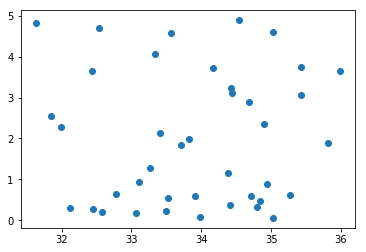

In [24]:
ra, dec = make_radec_in_cell(7, 40)

plt.plot(ra, dec, 'o')